### Bài tập
##### 1. Hãy dùng thuật toán K-mean để chọn ra số cụm thích hợp (như trong slide bài giảng) dựa trên tập training, và dự đoán label của các quan sát trên tập testing của bộ dữ liệu bên dưới.


In [1]:
import pandas as pd
import numpy as np
from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
rnd = np.random.RandomState(3)

# Tìm nhãn mới cho các điểm khi biết tâm cụm
def kmeans_assign_labels(X, centroids):
    '''
    - Gán nhãn mới cho các điểm dữ liệu khi biết centroids
    - Các tham số:
    ------------------
    X : numpy.ndarray/DataFrame
        Dữ liệu đầu vào
        
    centroids : numpy.ndarray
        Danh sách các điểm tâm cụm (centroid)
    - Trả về:
    ------------------
    Nhãn mới của từng mẫu trong X ứng với tâm cụm gần nhất.
    '''
    #Tính khoảng cách giữa X và tâm cụm
    D = cdist(X, centroids)
    #Trả về Tâm cụm gần nhất
    return np.argmin(D, axis = 1)

#Kiểm tra tính hội tụ, điều kiện dừng của bài toán
def has_converged(centroids, new_centroids):
    '''
    - Kiểm tra tính hội tụ và điều kiện dừng của bài toán.
    - Các tham số:
    ------------------
    centroids : numpy.ndarray
        Danh sách các điểm tâm cụm ban đầu.
        
    new_centroids : numpy.ndarray
        Danh sách các điểm tâm cụm mới.
    - Trả về:
    ------------------
    True nếu 2 tâm cụm là như nhau, ngược lại là False.
    '''
    #Trả về True nếu tập hợp 2 tâm cụm là như nhau
    return (set([tuple(a) for a in centroids]) == set([tuple(a) for a in new_centroids]))

#Cập nhật Tâm cụm khi biết nhãn của từng điểm
def kmeans_update_centroids(X, labels, K):
    '''
    - Cập nhật lại tâm cụm khi biết nhãn của từng dữ liệu.
    - Các tham số:
    ------------------
    X : numpy.ndarray/DataFrame
        Dữ liệu đầu vào.
    labels : numpy.ndarray
        Danh sách nhãn của từng mẫu trong dữ liệu.
    K : int
        Số tâm cụm.
    - Trả về:
    ------------------
    centroids : numppy.ndarray
        Danh sách các tâm cụm mới.
    '''
    centroids = np.zeros((K, X.shape[1]))
    for k in range(K):
        #Tập hợp tất cả các điểm mà ứng với tâm cụm thứ k
        if isinstance(X, pd.DataFrame):
            Xk = X.loc[labels == k, :]
        else:
            Xk = X[labels == k, :]
        #Tính trung bình
        centroids[k,:] = np.mean(Xk, axis = 0)
    return centroids


#Khởi tạo tâm cụm
def kmeans_init_centroids(X, n_cluster):
    '''
    - Khởi tạo các điểm đại diện (centroid) ban đầu
    - Các tham số:
    ------------------
    X : numpy.ndarray/DataFrame
        Dữ liệu đầu vào
        
    n_cluster : int
        Số centroid
    - Trả về:
    ------------------
    Danh sách k điểm ngẫu nhiên trong X làm centroids
    '''
    
    # Chọn ngẫu nhiên n_cluster dòng của X để tạo tâm cụm
    if isinstance(X, pd.DataFrame): # kiểm tra X có phải là 1 DataFrame hay không
        return X.loc[rnd.choice(X.shape[0], n_cluster, replace=False)]
    return X[rnd.choice(X.shape[0], n_cluster, replace=False)]


def kmeans(X, n_clusters):
    '''
    - Thực thi thuật toán K-Means
    - Các tham số:
    ------------------
    X : numpy.ndarray/DataFrame
        Dữ liệu đầu vào.
        
    n_clusters : int
        Số tâm cụm (số cụm).
    - Trả về:
    ------------------
    centroids : numpy.ndarray
        Danh sách các tâm cụm sau mỗi lần thực thi thuật toán K-Means.
        
    labels : numpy.ndarray
        Danh sách nhãn của từng mẫu trong dữ liệu ban đầu sau mỗi lần thực thi thuật toán.
        
    times : int
        Số lần lặp lại bước 2 và 3 để cho ra kết quả cuối cùng.
    '''
    centroids = [kmeans_init_centroids(X, n_clusters)]
    labels = []
    times = 0 
    while True:
        labels.append(kmeans_assign_labels(X, centroids[-1]))
        new_centroids = kmeans_update_centroids(X, labels[-1], n_clusters)
        if has_converged(centroids[-1], new_centroids):
            break
        centroids.append(new_centroids)
        times += 1
    return (centroids, labels, times)

# Tính tổng bình phương sai số SSE
def SSE(X, centroids):
    '''
    - Tính tổng bình phương sai số của toàn bộ dữ liệu X.
    - Các tham số:
    ------------------
    X : numpy.ndarray/DataFrame
        Dữ liệu đầu vào.
        
    centroids : numpy.ndarray
        Các tâm cụm cuối cùng sau khi thực thi thuật toán K-Means.
    - Trả về:
    ------------------
    sse : float
        Tổng bình phương sai số toàn bộ dữ liệu.
    '''
    D = cdist(X, centroids, 'euclidean')
    dist = np.min(D, axis=1)
    sse = sum(dist**2)
    return sse

In [3]:
data=pd.read_csv("https://raw.githubusercontent.com/huynhthanh98/ML/master/lab-05/data.csv")
data['Genre'] = data['Genre'].replace(['Male','Female'],[0,1])
data.head()

,CustomerID,Genre,Age,Annual Income (k$),Spending Score (1-100)
0,1,0,19,15,39
1,2,0,21,15,81
2,3,1,20,16,6
3,4,1,23,16,77
4,5,1,31,17,40


In [4]:
data.describe()

,CustomerID,Genre,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000,200.000000,200.000000
mean,100.500000,0.560000,38.850000,60.560000,50.200000
std,57.879185,0.497633,13.969007,26.264721,25.823522
min,1.000000,0.000000,18.000000,15.000000,1.000000
25%,50.750000,0.000000,28.750000,41.500000,34.750000
50%,100.500000,1.000000,36.000000,61.500000,50.000000
75%,150.250000,1.000000,49.000000,78.000000,73.000000
max,200.000000,1.000000,70.000000,137.000000,99.000000


In [5]:
#Check data có NULL hay không
data.isnull().sum()

CustomerID                0
Genre                     0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64

In [6]:
#Drop duplicates 
data.drop_duplicates(inplace=True)

In [7]:
X = data.iloc[:, [2, 3]].values
X_train, X_test = train_test_split(X, test_size=0.33, random_state=42)
np.random.seed(42)

In [8]:
# X_train=data.values
# np.random.seed(32)
# #Khởi tạo các centroids
# init_centroids=X_train[np.random.choice(X.shape[0],5,replace=False)]
# init_centroids

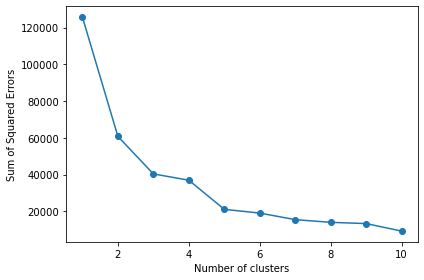

In [9]:
distortions = []
for i in range(1, 11):
    (centroids, labels, times) = kmeans(X_train, i)
    sse = SSE(X_train, centroids[-1])
    distortions.append(sse)
plt.plot(range(1, 11), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Sum of Squared Errors')
plt.tight_layout()
plt.show()

Ta chọn n_cluster=5

In [10]:
X_train=data.values
np.random.seed(32)
#Khởi tạo các centroids
init_centroids=X_train[np.random.choice(X.shape[0],5,replace=False)]
init_centroids

array([[123,   1,  40,  69,  58],
       [187,   1,  54, 101,  24],
       [168,   1,  33,  86,  95],
       [102,   1,  49,  62,  48],
       [ 30,   1,  23,  29,  87]], dtype=int64)

##### 2. Vẽ hình các cụm trên tập testing

In [11]:
X_np=X_test
(centroids, labels, times) = kmeans(X_np, 5)
print('Centers found by our algorithm:\n', centroids[-1])
X = X_np
y = labels[-1]
centers = centroids[-1]
label = np.unique(y)
marker = ['o', 'v', 's','^','P']
plt_colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k'] # danh sách các màu hỗ trợ
#Minh hoạ kết quả
fig, ax = plt.subplots()
for i, m in zip(label, marker):
    ax.scatter(X[y == i][:, 0], X[y == i][:, 1], edgecolor='k', marker=m, label = 'cluster_' + str(i))
    ax.plot(centers[i][0], centers[i][1], plt_colors[i+2] + 'o', markersize = 10, label = 'center_' + str(i)) # Vẽ tâm cụm i lên đồ thị
plt.legend(bbox_to_anchor=(1.05, 1), ncol=2, borderaxespad=0.)
plt.title('Result using our K-Means algorithm')
plt.show()

C:\Users\Tran Tan Phong\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\Tran Tan Phong\anaconda3\lib\site-packages\numpy\core\_methods.py:162: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


KeyboardInterrupt: 

array([1, 5, 4, 2, 8, 9, 9, 8, 2, 0, 1, 9, 0, 0, 6, 7, 1, 5, 5, 7, 9, 1,
       5, 8, 1, 9, 7, 8, 6, 3, 9, 6, 6, 0, 6, 1, 9, 9, 4, 9, 1, 4, 9, 2,
       2, 6, 3, 9, 4, 9, 4, 1, 9, 1, 1, 4, 9, 9, 6, 6, 5, 9, 7, 8, 5, 8,
       0, 2, 8, 0, 6, 0, 7, 9, 5, 2, 5, 8, 4, 1, 6, 4, 0, 7, 2, 5, 7, 1,
       6, 7, 5, 9, 6, 4, 5, 0, 5, 5, 7, 7, 7, 7, 3, 8, 8, 0, 6, 4, 2, 3,
       9, 8, 9, 3, 6, 8, 9, 2, 9, 0, 0, 4, 0, 4, 9, 3, 6, 5, 7, 4, 6, 7,
       5, 4], dtype=int64)